In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import kagglehub

In [2]:
# Veri setini indirin
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

100%|██████████| 163M/163M [00:08<00:00, 20.9MB/s]

Extracting files...


In [3]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [4]:
data_dir = '/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data'

In [5]:
categories = os.listdir(data_dir)
filepaths = []
labels = []

In [6]:
for category in categories:
    category_path = os.path.join(data_dir, category)
    for filename in os.listdir(category_path):
        filepaths.append(os.path.join(category_path, filename))
        labels.append(category)

In [7]:
train_files, test_files, train_labels, test_labels = train_test_split(filepaths, labels, test_size=0.2, random_state=42)

In [8]:
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.2, random_state=42)

In [9]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [13]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [14]:
train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'label': train_labels}),
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4833 validated image filenames belonging to 2 classes.


In [15]:
val_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'label': val_labels}),
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1209 validated image filenames belonging to 2 classes.


In [16]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
 27/152 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - accuracy: 0.8253 - loss: 0.3885

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


152/152 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.9153 - loss: 0.2219 - val_accuracy: 0.7320 - val_loss: 2.8813 - learning_rate: 0.0010
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 425ms/step - accuracy: 0.9700 - loss: 0.0822 - val_accuracy: 0.9446 - val_loss: 0.2955 - learning_rate: 0.0010
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 424ms/step - accuracy: 0.9710 - loss: 0.0801 - val_accuracy: 0.9355 - val_loss: 0.1869 - learning_rate: 0.0010
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 425ms/step - accuracy: 0.9781 - loss: 0.0674 - val_accuracy: 0.9884 - val_loss: 0.0469 - learning_rate: 0.0010
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 424ms/step - accuracy: 0.9812 - loss: 0.0571 - val_accuracy: 0.9371 - val_loss: 0.4215 - learning_rate: 0.0010
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 429ms/step - accuracy: 0.9824 - loss: 0.0582 - val_accuracy: 0.9644 - val_loss: 0.1087 - learning_rate: 0.0010
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 424ms/step - accuracy: 0.9725 - l

In [17]:
test_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_files, 'label': test_labels}),
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1511 validated image filenames belonging to 2 classes.


In [18]:
# Test tahminleri
preds = model.predict(test_generator)
pred_classes = np.argmax(preds, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 44s 682ms/step


In [19]:
# Rapor ve metrikler
print(classification_report(test_generator.classes, pred_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       732
           1       1.00      0.99      0.99       779

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



In [20]:
# ROC Eğrisi
fpr, tpr, _ = roc_curve(test_generator.classes, preds[:, 1])
roc_auc = auc(fpr, tpr)

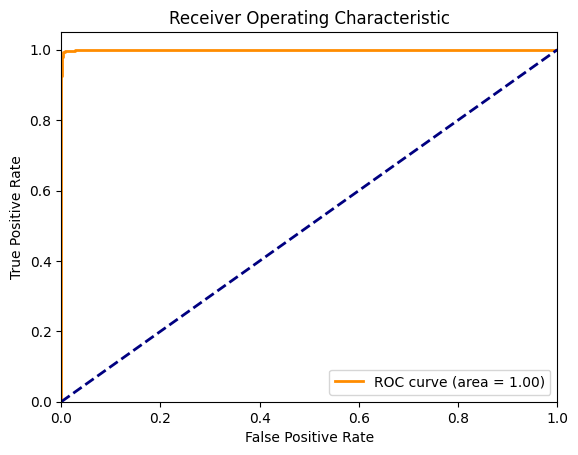

In [21]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

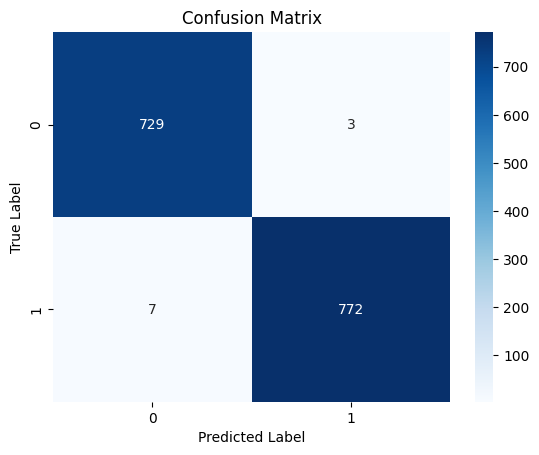

In [22]:
# Karışıklık Matrisi
conf_matrix = confusion_matrix(test_generator.classes, pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
model.save("face_mask_detect.h5")